# Setup

In [1]:
import sys 
sys.path.append('../')
from IPython.display import display
import pandas as pd 
import pickle
import os 
import re 
import pickle

from utils.env import EvoD4jEnv
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc
from scipy.stats import pearsonr
import seaborn as sns

def convert_docker_to_local_path(path):
    path  = path.replace("/root/workspace","/home/coinse/Workspace/hslee_workspace/autooracle/workspace")
    return path

def convert_to_prompt_path(chat_reply_file_path):
    if "chat_reply_mut" in chat_reply_file_path:
        chat_reply_file_path = chat_reply_file_path.replace("chat_reply_mut", "prompt")
    else:
        chat_reply_file_path = chat_reply_file_path.replace("chat_reply", "prompt")
    prompt_path = chat_reply_file_path.split('/')
    del prompt_path[-2]
    if prompt_path[-1].endswith("reply.txt"):
        prompt_path[-1] = prompt_path[-1].replace("reply.txt","query.txt")
    prompt_path = '/'.join(prompt_path)
    return prompt_path

def extract_label(path):
    with open(path, 'r') as file:
        file_content = file.read()
    lines = file_content.split('\n')
    for line in reversed(lines):
        if 'undecidable' in line.lower():
            return 'undecidable'
        elif 'incorrect' in line.lower():
            return 'incorrect'
        elif 'correct' in line.lower():
            return 'correct'
        else:
            pass
    # If no label is found, return None
    return "None"

def get_docmumet_length(prompt_path):
    with open(prompt_path,'r') as f:
        prompt = f.readlines()
    words = []
    isdocument=False
    for line in prompt:
        if line.find("signature:") != -1:
            isdocument = True
            continue
        if isdocument:
            if line.find("```") != -1:
                isdocument= False
                continue
            words.extend(line.strip().split())
        if not isdocument and len(words) > 0:
            break
    return len(words)

def process_test_info(file_name, chat_reply_file_path):
    test_infos = file_name.split('_')
    test_class = test_infos[0]
    test_no = test_infos[1]
    oracle_type = test_infos[2]
    document_length = get_docmumet_length(convert_to_prompt_path(chat_reply_file_path))
    return test_class, test_no, oracle_type, document_length

def get_idx_chat_reply_result(project, version, idx, ts_id, prompt_no, example_num):
    env = EvoD4jEnv(project, version, idx, ts_id)
    chat_reply_org_root_path = convert_docker_to_local_path(os.path.join(env.evosuite_chat_reply_dir, f'prompt{prompt_no}', f'example{example_num}'))
    chat_reply_trs_root_path = convert_docker_to_local_path(os.path.join(env.evosuite_chat_reply_transform_dir, f'prompt{prompt_no}', f'example{example_num}'))

    idx_test_info = {} # key: test_no, value : [(result1 info), result2, result3, result4, result5]
    idx_test_result = {} # 
    for root_path in [chat_reply_org_root_path, chat_reply_trs_root_path]:
        for try_no in range(1, 6):
            chat_reply_path = os.path.join(root_path, f'try{try_no}')
            for file_name in os.listdir(chat_reply_path):
                chat_reply_file_path = os.path.join(chat_reply_path, file_name)
                label = extract_label(chat_reply_file_path)
                test_class, test_no, oracle_type, document_length = process_test_info(file_name, chat_reply_file_path)
                idx_test_info.setdefault(test_no, [test_class, oracle_type, document_length])
                idx_test_result.setdefault(test_no, []).append(label)

    return idx_test_info, idx_test_result


def process_test_info_df(project, info_dict, result_dict, sample_num, gt_label):
    df_rows = []
    for idx, tests_dict in info_dict.items():
        for test_no, info_list in tests_dict.items():
            df_rows.append({
                'project': project,
                'version': '1',
                'idx': idx,
                'ts_id': 'newTS_300',
                'test_no': test_no,
                'test_class': info_list[0],
                'type': info_list[1],
                'document_length': info_list[2],
                'ground_truth': gt_label,
                'attempt_org': result_dict[idx][test_no][:sample_num],
                'attempt_trs': result_dict[idx][test_no][5: 5 + sample_num]
            })
    return pd.DataFrame(df_rows)

def score_org(attempt_list):
    score = 0
    for reply in attempt_list:
        if reply == "correct":
            score += 1
        elif reply == "incorrect":
            score -= 1
        elif reply == "undecidable":
            score += 0
        else: 
            score += 0
    return score

def score_trs(attempt_list):
    score = 0
    for reply in attempt_list:
        if reply == "correct":
            score -= 1
        elif reply == "incorrect":
            score += 1
        elif reply == "undecidable":
            score += 0
        else: 
            score += 0
    return score

def get_fail_pass_df(project, version, ts_id, prompt_no, example_no, sample_num):
    fail_info, fail_result, pass_info, pass_result = all_chat_reply_result(project, version, ts_id, prompt_no, example_no)
    # Create DataFrames for fail and pass results
    fail_df = process_test_info_df(project, fail_info, fail_result, sample_num, "incorrect")
    pass_df = process_test_info_df(project, pass_info, pass_result, sample_num, "correct")

    fail_df["score_org"] = fail_df["attempt_org"].apply(score_org)
    fail_df["score_trs"] = fail_df["attempt_trs"].apply(score_trs)
    fail_df["score"] = fail_df["score_org"] + fail_df["score_trs"]
    #fail_df["score"] = 0 + fail_df["score_trs"]

    pass_df["score_org"] = pass_df["attempt_org"].apply(score_org)
    pass_df["score_trs"] = pass_df["attempt_trs"].apply(score_trs)
    pass_df["score"] = pass_df["score_org"] + pass_df["score_trs"]
    #pass_df["score"] = 0 + pass_df["score_trs"]
    return fail_df, pass_df

def all_chat_reply_result(project, version, ts_id, prompt_no, example_no):
    with open(f'/home/coinse/Workspace/hslee_workspace/autooracle/workspace/src/select_dataset/{project}_tests.pkl',"rb") as fw:
        dataset_info = pickle.load(fw)
    all_fail_idx_test_info = {}
    all_fail_idx_test_result = {}
    all_pass_idx_test_info = {}
    all_pass_idx_test_result = {}
    for idx, [fail_tests, pass_tests] in dataset_info.items():
        idx_test_info, idx_test_result = get_idx_chat_reply_result(project, version, str(idx), ts_id, prompt_no, example_no)
        
        fail_test_info = {test_no: info for test_no, info in idx_test_info.items() if test_no in fail_tests}
        fail_test_result = {test_no: label for test_no, label in idx_test_result.items() if test_no in fail_tests}

        pass_test_info = {test_no: info for test_no, info in idx_test_info.items() if test_no in pass_tests}
        pass_test_result = {test_no: label for test_no, label in idx_test_result.items() if test_no in pass_tests}

        all_fail_idx_test_info[idx] = fail_test_info
        all_fail_idx_test_result[idx] = fail_test_result
        all_pass_idx_test_info[idx] = pass_test_info
        all_pass_idx_test_result[idx] = pass_test_result
    return all_fail_idx_test_info, all_fail_idx_test_result, all_pass_idx_test_info, all_pass_idx_test_result


# Visualization

In [2]:
import matplotlib.pyplot as plt
from IPython.display import Image
from collections import Counter
import seaborn as sns
import csv
import numpy as np

def plot_countplot(ax, data, x, color):
    a = sns.countplot(data=data, x=x, color=color)
    plot_sum = 0
    for p in a.patches:
        height = p.get_height()
        plot_sum += height
    for p in a.patches:
        height = p.get_height()
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)
        #ax.annotate(f'{height/plot_sum * 100:.2f}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)
    ax.set_xlabel("Predict", fontsize=10)
    ax.set_ylabel("number of test", fontsize=10)

def count_plot(fail_df, pass_df):
    plt.figure(figsize=(12, 8))

    # Original Plots
    plt.subplot(2, 3, 1)
    plt.title("Original_fail", fontdict={'fontsize': 10})
    plot_countplot(plt.gca(), fail_df, "score_org", '#4BC6CC')

    plt.subplot(2, 3, 4)
    plt.title("Original_pass", fontdict={'fontsize': 10})
    plot_countplot(plt.gca(), pass_df, "score_org", '#4BC6CC')

    # Transformed Plots
    plt.subplot(2, 3, 2)
    plt.title("Transformed_fail", fontdict={'fontsize': 10})
    plot_countplot(plt.gca(), fail_df, "score_trs", '#FF6E3E')

    plt.subplot(2, 3, 5)
    plt.title("Transformed_pass", fontdict={'fontsize': 10})
    plot_countplot(plt.gca(), pass_df, "score_trs", '#FF6E3E')
    # Sum Plots
    fail_df["score"] = fail_df["score_org"] + fail_df["score_trs"]
    plt.subplot(2, 3, 3)
    plt.title("Sum[Incorrect Oracle]", fontdict={'fontsize': 10})
    plot_countplot(plt.gca(), fail_df, "score", 'dodgerblue')

    pass_df["score"] = pass_df["score_org"] + pass_df["score_trs"]
    plt.subplot(2, 3, 6)
    plt.title("Sum[Correct Oracle]", fontdict={'fontsize': 10})
    plot_countplot(plt.gca(), pass_df, "score", 'dodgerblue')

    plt.tight_layout()
    plt.show()

def hist_plot(fail_df, pass_df):
    fail_df["ground_truth"] = "incorrect"
    pass_df["ground_truth"] = "correct"
    pred_df = pd.concat([fail_df, pass_df])
    sns.histplot(data=pred_df, x="score", hue="ground_truth", multiple="dodge")
    plt.yscale("log")

def accumulate_incorrect_ratio_graph(pred_df):
    prediction_columns = ["score", "score_org", "score_trs"]
    plt.figure(figsize=(13, 5))
    for i, col in enumerate(prediction_columns):
        # plt.subplot(1, len(prediction_columns), i+1)
        thresholds = range(pred_df[col].min(), pred_df[col].max() +1)
        incorrect_ratio = [(pred_df[pred_df[col] <= score].ground_truth == "incorrect").mean() for score in thresholds]
        scores = [ 2 * th /(max(thresholds) - min(thresholds)) for th in thresholds]
        plt.plot(scores, incorrect_ratio, marker=".", label=col)

    plt.hlines((pred_df.ground_truth == "incorrect").mean(), min(scores), max(scores), color="red", label="% incorrect tests")
    plt.xlabel("th")
    plt.ylabel("% incorrect tests with score <= th")
    plt.legend()
    plt.ylim((-0.05, 1.05))
    plt.show()
    
def incorrect_ratio_plot_graph(project, prompt_no, fail_df, pass_df, pred_df):
    prediction_columns = ["score", "score_org", "score_trs"]
    plot_data = []
    
    for col in prediction_columns:
        fail_counts = fail_df[col].value_counts()
        pass_counts = pass_df[col].value_counts()
        total_counts = fail_counts.add(pass_counts, fill_value=0)
        failing_ratio = fail_counts / total_counts
        min_score = pred_df[col].min()
        max_score = pred_df[col].max()
        if col == 'score':
            score_range = 20
        else:
            score_range = 10
        #score_range = max_score - min_score
        
        for score, ratio in failing_ratio.items():
            scaled_score = (2 * score / score_range)
            plot_data.append({
                'Scaled Score': scaled_score ,
                'Failing Ratio': ratio,
                'Prediction Column': col,
                'Text': f'{fail_counts.get(score, 0)}/{int(total_counts.get(score, 0))}'  # Store the ratio text
            })
    
    plot_df = pd.DataFrame(plot_data)

    color_palette = {"score": "tab:blue", "score_org": "tab:orange", "score_trs": "tab:green"}

    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Scaled Score', y='Failing Ratio', hue='Prediction Column', marker="o", data=plot_df, palette=color_palette)
    plt.grid()
    x_lims = plt.xlim()  # Get current x-axis limits
    plt.hlines((pred_df.ground_truth == "incorrect").mean(), x_lims[0], x_lims[1], color="red", label="% incorrect tests")
   
    plt.xlabel(" Score")
    plt.ylabel("Failing Ratio")
    plt.title("Failing Ratio by Scaled Score for Each Prediction score")
    plt.legend()
    plt.tight_layout()
    plt.show()
    if not os.path.exists(f'{project}_{prompt_no}_row.csv'):
        with open(f'{project}_{prompt_no}_row.csv',"w") as f:
            for _, row in plot_df.iterrows():
                f.write(f"Column: {row['Prediction Column']}, Scaled Score: {row['Scaled Score']:.2f}, Failing Ratio: {row['Failing Ratio']:.2f}, Counts: {row['Text']}\n")

def incorrect_ratio_bar_graph(fail_df, pass_df, pred_df):
    prediction_columns = ["score", "score_org", "score_trs"]
    plot_data = []
    
    for col in prediction_columns:
        fail_counts = fail_df[col].value_counts()
        pass_counts = pass_df[col].value_counts()
        total_counts = fail_counts.add(pass_counts, fill_value=0)
        failing_ratio = fail_counts / total_counts
        min_score = pred_df[col].min()
        max_score = pred_df[col].max()
        score_range = max_score - min_score
        
        for score, ratio in failing_ratio.items():
            scaled_score = (2 * score / score_range)
            plot_data.append({
                'Scaled Score': scaled_score ,
                'Failing Ratio': ratio,
                'Prediction Column': col
            })
    
    plot_df = pd.DataFrame(plot_data)

    color_palette = {"score": "tab:blue", "score_org": "tab:orange", "score_trs": "tab:green"}

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Scaled Score', y='Failing Ratio', hue='Prediction Column', data=plot_df, palette=color_palette)
    plt.grid()
    x_lims = plt.xlim()  # Get current x-axis limits
    plt.hlines((pred_df.ground_truth == "incorrect").mean(), x_lims[0], x_lims[1], color="red", label="% incorrect tests")
 
    plt.xlabel(" Score")
    plt.ylabel("Failing Ratio")
    plt.title("Failing Ratio by Scaled Score for Each Prediction Score")
    plt.legend()
    plt.tight_layout()
    plt.show()

def precision_heatmap(pred_df):
    rat_rows_precision = []
    for org_score in range(-5, 6):
        for trs_score in range(-5, 6):
            # True Positives (TP): Ground truth is "incorrect" and predicted as "incorrect"
            TP = ((pred_df.score_org <= org_score) & (pred_df.score_trs <= trs_score) & (pred_df.ground_truth == "incorrect")).sum()
            # False Positives (FP): Ground truth is "correct" but predicted as "incorrect"
            FP = ((pred_df.score_org <= org_score) & (pred_df.score_trs <= trs_score) & (pred_df.ground_truth == "correct")).sum()
            # Calculate precision
            precision = TP / (TP + FP) if (TP + FP) > 0 else 0
            rat_rows_precision.append((org_score, trs_score, precision))

    # Create precision dataframe and heatmap
    plt.figure(figsize=(10, 10))
    rat_df_precision = pd.DataFrame(data=rat_rows_precision, columns=["org_th", "trs_th", "precision"]).pivot("org_th", "trs_th", "precision")
    sns.heatmap(rat_df_precision, annot=True, fmt=".2f", cmap="Reds")
    
    plt.xlabel("Threshold for Transformation Score")
    plt.ylabel("Threshold for Original Score")
    plt.title("Precision Heatmap")
    plt.show()

def document_length_graph(pred_df):
    score_doclen = []
    for score in range(0, 11):
        document_length = pred_df[(pred_df.score == score) | (pred_df.score == -score)].document_length.mean()
        score_doclen.append((score, document_length))
    score_doclen_df = pd.DataFrame(data=score_doclen, columns=["score","doc_leng"])
    plt.plot(score_doclen_df["score"],score_doclen_df["doc_leng"], marker=".")
    
    print("doc_pearsonr:",pearsonr(score_doclen_df["doc_leng"], score_doclen_df["score"]))
    sns.scatterplot(data= pred_df, x = "score", y = "document_length")
    plt.xlabel("|score|")
    plt.ylabel("Document Length")
    plt.legend()
    plt.title("Correlation btw score and Doc_length")

def boxplot_pearsonr(pred_df):
    plt.figure(figsize=(5, 5))
    sns.set_theme(style='whitegrid')
    pred_df["is_correct"] = pred_df["ground_truth"] == "correct"
    sns.boxplot(data=pred_df, x="ground_truth", y="score")
    print("pearsonr:",pearsonr(pred_df["is_correct"], pred_df["score"])) # point - biserial correlation coefficient

def distplot(pred_df):
    plt.figure(figsize=(5, 5))
    sns.displot(data=pred_df, hue="ground_truth", x="score", kde=True, multiple='dodge')

def roc_auc(pred_df):
    #plt.figure(figsize=(5, 5))
    pred_df.loc[pred_df["ground_truth"]=="incorrect",["label"]] = 1
    pred_df.loc[pred_df["ground_truth"]=="correct",["label"]] = 0
    suspiciousness = -(pred_df.score - pred_df.score.min())/(pred_df.score.max() - pred_df.score.min()) # 0 ~ 1
    fprs, tprs, thresholds = roc_curve(pred_df.label.astype(bool), suspiciousness)
    print('roc_acu_score:', "{:.4f}".format(roc_auc_score(pred_df.label.astype(bool), suspiciousness)))
    #plt.plot(fprs, tprs, label = f'prompt')
    #plt.xlabel('FPR')
    #plt.ylabel('TPR')
    #plt.title("ROC Curve")
    #plt.legend()

def prec_recall(pred_df):
    #plt.figure(figsize=(5, 5))
    pred_scores = -(pred_df.score)
    suspiciousness = (pred_scores - pred_scores.min())/(pred_scores.max() - pred_scores.min()) # 0 ~ 1
    pre, rec, th = precision_recall_curve(pred_df.label.astype(bool), suspiciousness)
    pr_auc=auc(rec, pre)
    print(f'pr_auc:{pr_auc:.4f}')
    plt.plot(rec, pre, label = f'PR AUC: {pr_auc:.4f}')
    plt.xlabel('rec')
    plt.ylabel('pre')
    plt.title("precision_recall curve")
    plt.legend()


## Save Data

In [9]:
projects = ["Chart", "Lang", "Math", "Closure", "Time"]

for project in projects:
    version = "1"
    ts_id = "newTS_300"
    prompt_no = 8
    example_num = 0
    sample_num = 5

    fail_df, pass_df = get_fail_pass_df(project, version, ts_id, prompt_no, example_num, sample_num)
    pred_df = pd.concat([fail_df, pass_df])
    with open(f'{project}_Dataframe_8.pkl','wb') as f:
        pickle.dump(pred_df, f)

# Analysis

### 1. Load Data

In [20]:
projects = ["Chart", "Lang", "Math", "Closure", "Time"]

total_df_8=pd.DataFrame()
total_df_10=pd.DataFrame()

for project in projects:
    with open(f'{project}_Dataframe_8.pkl','rb') as f:
        df_8 = pickle.load(f)
    fail_df = df_8[df_8.ground_truth == "incorrect"]
    pass_df = df_8[df_8.ground_truth == "correct"]
    total_df_8 = pd.concat([total_df_8, df_8])
display(total_df_8)
display(total_df_8[(total_df_8.ground_truth == "correct")&(total_df_8.score == -10)])

,project,version,idx,ts_id,test_no,test_class,type,document_length,ground_truth,attempt_org,attempt_trs,score_org,score_trs,score
0,Chart,1,5040,newTS_300,test0,org.jfree.chart.annotations,assertTrue,23,incorrect,"[correct, undecidable, undecidable, correct, c...","[correct, correct, correct, correct, correct]",3,-5,-2
1,Chart,1,5037,newTS_300,test25,org.jfree.chart.annotations,assertTrue,23,incorrect,"[incorrect, undecidable, incorrect, incorrect,...","[undecidable, incorrect, incorrect, undecidabl...",-4,2,-2
2,Chart,1,5048,newTS_300,test22,org.jfree.chart.annotations,assertTrue,23,incorrect,"[undecidable, correct, undecidable, correct, u...","[correct, correct, correct, correct, correct]",2,-5,-3
3,Chart,1,5048,newTS_300,test19,org.jfree.chart.annotations,assertTrue,23,incorrect,"[correct, incorrect, correct, correct, correct]","[correct, correct, correct, incorrect, correct]",3,-3,0
4,Chart,1,957,newTS_300,test0,org.jfree.chart.axis,assertEquals,53,incorrect,"[undecidable, undecidable, undecidable, undeci...","[undecidable, undecidable, undecidable, undeci...",0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,Time,1,1365,newTS_300,test15,org.joda.time.field,assertEquals,33,correct,"[undecidable, undecidable, undecidable, undeci...","[undecidable, undecidable, undecidable, undeci...",0,1,1
679,Time,1,1365,newTS_300,test11,org.joda.time.field,assertEquals,33,correct,"[undecidable, undecidable, undecidable, incorr...","[undecidable, undecidable, None, undecidable, ...",-2,0,-2
680,Time,1,1365,newTS_300,test0,org.joda.time.field,assertEquals,33,correct,"[undecidable, undecidable, undecidable, undeci...","[undecidable, incorrect, incorrect, undecidabl...",-1,2,1
681,Time,1,1364,newTS_300,test10,org.joda.time.field,assertEquals,33,correct,"[undecidable, undecidable, undecidable, undeci...","[undecidable, undecidable, undecidable, undeci...",0,0,0


,project,version,idx,ts_id,test_no,test_class,type,document_length,ground_truth,attempt_org,attempt_trs,score_org,score_trs,score
444,Time,1,287,newTS_300,test7,org.joda.time,assertSame,80,correct,"[incorrect, incorrect, incorrect, incorrect, i...","[correct, correct, correct, correct, correct]",-5,-5,-10


### 2. Document Length

프로젝트: Chart 점수 0 갯수: 990
프로젝트: Chart 점수 1 갯수: 1511
프로젝트: Chart 점수 2 갯수: 1066
프로젝트: Chart 점수 3 갯수: 679
프로젝트: Chart 점수 4 갯수: 477
프로젝트: Chart 점수 5 갯수: 260
프로젝트: Chart 점수 6 갯수: 218
프로젝트: Chart 점수 7 갯수: 98
프로젝트: Chart 점수 8 갯수: 118
프로젝트: Chart 점수 9 갯수: 27
프로젝트: Chart 점수 10 갯수: 42
doc_pearsonr: PearsonRResult(statistic=0.8115771577825479, pvalue=0.002421269437975059)
Chart
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
[28.76, 29.03, 28.86, 29.72, 29.21, 31.48, 29.24, 30.61, 30.84, 34.11, 32.31]
프로젝트: Closure 점수 0 갯수: 57
프로젝트: Closure 점수 1 갯수: 68
프로젝트: Closure 점수 2 갯수: 41
프로젝트: Closure 점수 3 갯수: 26
프로젝트: Closure 점수 4 갯수: 15
프로젝트: Closure 점수 5 갯수: 11
프로젝트: Closure 점수 6 갯수: 8
프로젝트: Closure 점수 7 갯수: 2
프로젝트: Closure 점수 8 갯수: 3
프로젝트: Closure 점수 9 갯수: 3
프로젝트: Closure 점수 10 갯수: 0
doc_pearsonr: PearsonRResult(statistic=0.4979383741551904, pvalue=0.14302370423565663)
Closure
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
[64.96, 64.78, 70.54, 69.73, 66.13, 64.09, 66.0, 58.0, 79.67, 87.67]
프로젝트: Lang 점수 0 갯수:

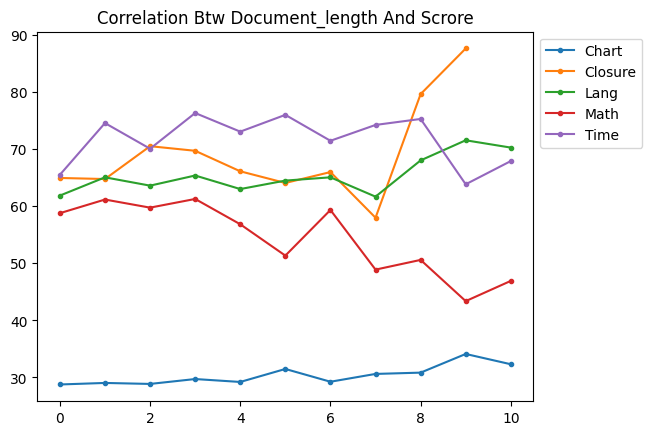

갯수: 1592 점수 0
갯수: 2431 점수 1
갯수: 1806 점수 2
갯수: 1231 점수 3
갯수: 944 점수 4
갯수: 566 점수 5
갯수: 524 점수 6
갯수: 268 점수 7
갯수: 364 점수 8
갯수: 101 점수 9
갯수: 217 점수 10
doc_pearsonr: PearsonRResult(statistic=0.9803923192165396, pvalue=1.1778635261639248e-07)
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
[41.29, 43.08, 43.33, 46.49, 46.69, 48.95, 50.52, 51.3, 56.0, 57.13, 61.39]


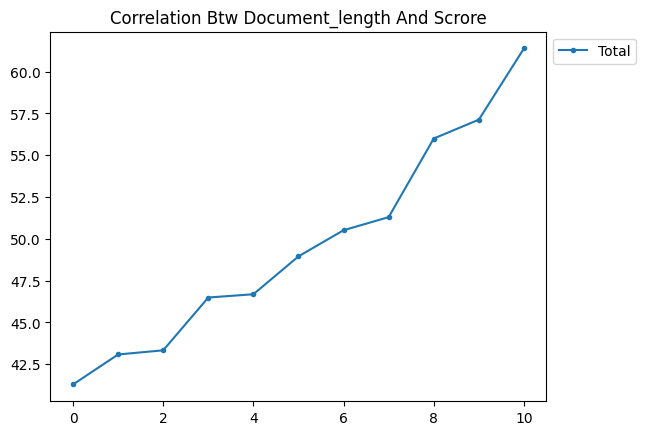

In [5]:
projects = ["Chart", "Closure", "Lang", "Math", "Time"]
total_df_8 = pd.DataFrame()
for project in projects:
    with open(f'{project}_Dataframe_8_5_DOC.pkl','rb') as f:
        df_8 = pickle.load(f)
    total_df_8 = pd.concat([total_df_8, df_8])
    score_doclen = {}
    for score in range(0, 11):
        abs_score_df = df_8[(df_8.score == score) | (df_8.score == -score)]
        print('프로젝트:', project, '점수', score, '갯수:', len(abs_score_df))        
        if not abs_score_df.empty:
            score_doclen[score] =  abs_score_df.document_length.mean()
    score_doclen_df = pd.DataFrame(list(score_doclen.items()),columns=["score","length"])
    print("doc_pearsonr:",pearsonr(score_doclen_df["length"], score_doclen_df["score"]))
    print(f"{project}")
    print(score_doclen.keys())
    a= map(lambda x : round(x,2), score_doclen.values())
    print(list(a))
    plt.plot(score_doclen.keys(), score_doclen.values(), marker=".", label=f"{project}")
    
plt.title("Correlation Btw Document_length And Scrore")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


score_doclen = {}
for score in range(0, 11):
    abs_score_df = total_df_8[(total_df_8.score == score) | (total_df_8.score == -score)]
    print('갯수:',len(abs_score_df),'점수',score) 
    if not abs_score_df.empty:
        score_doclen[score] =  abs_score_df.document_length.mean()
score_doclen_df = pd.DataFrame(list(score_doclen.items()),columns=["score","length"])
print("doc_pearsonr:",pearsonr(score_doclen_df["length"], score_doclen_df["score"]))
print(score_doclen.keys())
a= map(lambda x : round(x,2), score_doclen.values())
print(list(a))
plt.plot(score_doclen.keys(), score_doclen.values(), marker=".", label=f"Total")

plt.title("Correlation Btw Document_length And Scrore")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()
    


### 3. Classifier

### 1) k-fold validation

In [6]:
total_df_8.loc[total_df_8["ground_truth"]=="incorrect",["label"]] = 1 
total_df_8.loc[total_df_8["ground_truth"]=="correct",["label"]] = 0

def count_occurrences(attempt_list, label):
    return attempt_list.count(label)

labels = ["correct", "undecidable", "incorrect"]
for label in labels:
    total_df_8[f"attempt_org_{label}_cnt"] = total_df_8["attempt_org"].apply(lambda x: count_occurrences(x, label))
    total_df_8[f"attempt_trs_{label}_cnt"] = total_df_8["attempt_trs"].apply(lambda x: count_occurrences(x, label))

from sklearn.model_selection import KFold
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, auc
# Prepare the entire dataset for cross-validation, no initial train/test split needed
X = total_df_8[["attempt_org_correct_cnt", "attempt_org_undecidable_cnt", "attempt_org_incorrect_cnt", "attempt_trs_correct_cnt", "attempt_trs_undecidable_cnt", "attempt_trs_incorrect_cnt"]]
y = total_df_8["label"]

# Initialize the KFold class
kf = KFold(n_splits=5, shuffle=True, random_state=42) # Adjust n_splits based on your preference

# Lists to store results of each fold
precisions = []
recalls = []
pr_aucs = []

for train_index, test_index in kf.split(X):
    # Split data into training and test for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Scale features
    scaler = MaxAbsScaler()
    s_X_train = scaler.fit_transform(X_train)
    s_X_test = scaler.transform(X_test)

    # Train model
    model = LogisticRegression(class_weight="balanced")
    model.fit(s_X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(s_X_test)
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))

    # Calculate precision-recall curve and AUC for each fold
    y_scores = model.predict_proba(s_X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
    pr_aucs.append(auc(recall, precision))

# Calculate average of each metric across all folds
print(f"Average Precision: {np.mean(precisions)}")
print(f"Average Recall: {np.mean(recalls)}")
print(f"Average Precision-Recall AUC: {np.mean(pr_aucs)}")


Average Precision: 0.6938150984160568
Average Recall: 0.6973388874851308
Average Precision-Recall AUC: 0.7808276363846357


### 2) Comparison with Score_based


0.5002488800398208
Precision: 0.6806231742940604
Recall: 0.6955223880597015
Precision-Recall AUC_Logistic Regression: 0.774796311623002


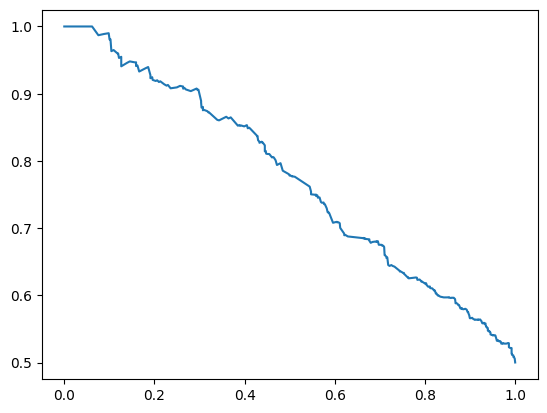

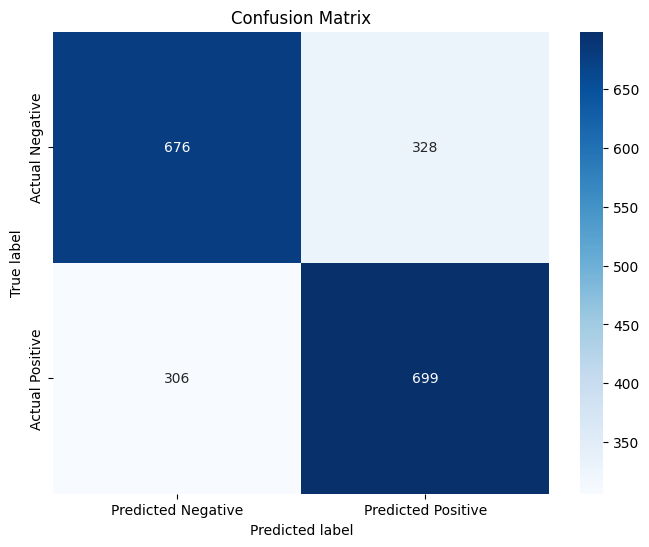

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, auc, roc_curve
from sklearn.metrics import confusion_matrix


X_train, X_test, y_train, y_test = train_test_split(total_df_8[["attempt_org_correct_cnt", "attempt_org_undecidable_cnt", "attempt_org_incorrect_cnt", "attempt_trs_correct_cnt", "attempt_trs_undecidable_cnt", "attempt_trs_incorrect_cnt"]], total_df_8["label"], test_size=0.20, stratify=total_df_8["label"])
scaler = MaxAbsScaler()
s_X_train = scaler.fit_transform(X_train)
model = LogisticRegression(class_weight="balanced")
model.fit(s_X_train,y_train)

s_X_test = scaler.transform(X_test)
y_pred = model.predict(s_X_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# For precision-recall curve and AUC, you need probability scores
print(y_test.mean())
print(f"Precision: {precision}")
print(f"Recall: {recall}")
y_scores = model.predict_proba(s_X_test)[:, 1]  
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC_Logistic Regression: {pr_auc}")
plt.plot(recall, precision, label = 'Logistic Regression')

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted Negative", "Predicted Positive"], yticklabels=["Actual Negative", "Actual Positive"])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


# #For Score_Based
# X_test["score_org"] = X_test.attempt_org_correct_cnt - X_test.attempt_org_incorrect_cnt
# X_test["score_trs"] = X_test.attempt_trs_incorrect_cnt - X_test.attempt_trs_correct_cnt
# pred_scores = X_test.score_org  + X_test.score_trs
# suspiciousness = -(pred_scores - pred_scores.min())/(pred_scores.max() - pred_scores.min()) # 0 ~ 1
# prec, rec, thresholds = precision_recall_curve(y_test.astype(bool), suspiciousness)
# # print(thresholds)
# # print(auc(rec, prec))
# plt.plot(rec, prec, label = "Score based")
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title("Precision-Recall Curve")

### 3. Cross project

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, auc, roc_curve
from itertools import combinations_with_replacement,product

def count_occurrences(attempt_list, label):
    return attempt_list.count(label)

projects =["Chart", "Closure", "Lang", "Math","Time"]

two_project_list = list(product(projects,repeat = 2))

for train_project, test_project in two_project_list:
    with open(f"{train_project}_Dataframe_8.pkl","rb") as f:
        train_df = pickle.load(f)
    with open(f"{test_project}_Dataframe_8.pkl","rb") as f:
        test_df = pickle.load(f)

    train_df.loc[train_df["ground_truth"]=="incorrect",["label"]] = 1 
    train_df.loc[train_df["ground_truth"]=="correct",["label"]] = 0
    test_df.loc[test_df["ground_truth"]=="incorrect",["label"]] = 1 
    test_df.loc[test_df["ground_truth"]=="correct",["label"]] = 0

    labels = ["correct", "undecidable", "incorrect"]
    for label in labels:
        train_df[f"attempt_org_{label}_cnt"] = train_df["attempt_org"].apply(lambda x: count_occurrences(x, label))
        train_df[f"attempt_trs_{label}_cnt"] = train_df["attempt_trs"].apply(lambda x: count_occurrences(x, label))
        test_df[f"attempt_org_{label}_cnt"] = test_df["attempt_org"].apply(lambda x: count_occurrences(x, label))
        test_df[f"attempt_trs_{label}_cnt"] = test_df["attempt_trs"].apply(lambda x: count_occurrences(x, label))

    # Train model with train_df
    print(f"Train Regression model with {train_project}")
    X_train, X_test, y_train, y_test = train_test_split(train_df[["attempt_org_correct_cnt", "attempt_org_undecidable_cnt", "attempt_org_incorrect_cnt", "attempt_trs_correct_cnt", "attempt_trs_undecidable_cnt", "attempt_trs_incorrect_cnt"]], train_df["label"], test_size=0.20, stratify=train_df["label"])
    scaler = MaxAbsScaler()
    s_X_train = scaler.fit_transform(X_train)
    model = LogisticRegression(class_weight="balanced")
    model.fit(s_X_train,y_train)

    # Test model with test_df
    X_Test_DF = test_df[["attempt_org_correct_cnt", "attempt_org_undecidable_cnt", "attempt_org_incorrect_cnt", "attempt_trs_correct_cnt", "attempt_trs_undecidable_cnt", "attempt_trs_incorrect_cnt"]]
    s_X_TEST_DF = scaler.transform(X_Test_DF)
    y_pred_chart = model.predict(s_X_TEST_DF)

    # Evaluate model performance on chart_df_8
    true_labels_chart = test_df["label"]
    precision = precision_score(true_labels_chart, y_pred_chart)
    recall = recall_score(true_labels_chart, y_pred_chart)
    print(f"Precision on {test_project}: {precision:.4f}")
    print(f"Recall on {test_project}: {recall:.4f}")
    precision, recall, thresholds = precision_recall_curve(true_labels_chart, model.predict_proba(s_X_TEST_DF)[:,1])
    pr_auc = auc(recall, precision)
    print(f"Precision-Recall AUC_Logistic Regression: {pr_auc:.4f}")
    print()
    print()

# # For precision-recall curve and AUC, you need probability scores
# print(y_test.mean())
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# y_scores = model.predict_proba(s_X_test)[:, 1]  
# precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
# pr_auc = auc(recall, precision)
# print(f"Precision-Recall AUC_Logistic Regression: {pr_auc}")
# plt.plot(recall, precision, label = 'Logistic Regression')


# X_chart = chart_df_8[["attempt_org_correct_cnt", "attempt_org_undecidable_cnt", "attempt_org_incorrect_cnt", "attempt_trs_correct_cnt", "attempt_trs_undecidable_cnt", "attempt_trs_incorrect_cnt"]]

# # Scaling `X_chart` using the same scaler object used for `X_train`
# # Important: Use .transform(), NOT .fit_transform()
# s_X_chart = scaler.transform(X_chart)

# # Predicting on `chart_df_8` using the trained model
# y_pred_chart = model.predict(s_X_chart)

# # If `chart_df_8` has a 'label' column for true labels, you can calculate performance metrics
# if 'label' in chart_df_8.columns:
#     true_labels_chart = chart_df_8["label"]
#     precision_chart = precision_score(true_labels_chart, y_pred_chart)
#     recall_chart = recall_score(true_labels_chart, y_pred_chart)

#     # Outputting precision and recall for `chart_df_8`
#     print(f"Precision on chart_df_8: {precision_chart}")
#     print(f"Recall on chart_df_8: {recall_chart}")


Train Regression model with Chart
Precision on Chart: 0.7539
Recall on Chart: 0.7616
Precision-Recall AUC_Logistic Regression: 0.8223


Train Regression model with Chart
Precision on Closure: 0.4800
Recall on Closure: 0.4103
Precision-Recall AUC_Logistic Regression: 0.5275


Train Regression model with Chart
Precision on Lang: 0.8168
Recall on Lang: 0.5736
Precision-Recall AUC_Logistic Regression: 0.8401


Train Regression model with Chart
Precision on Math: 0.6106
Recall on Math: 0.3309
Precision-Recall AUC_Logistic Regression: 0.5963


Train Regression model with Chart
Precision on Time: 0.6712
Recall on Time: 0.5827
Precision-Recall AUC_Logistic Regression: 0.7128


Train Regression model with Closure
Precision on Chart: 0.5530
Recall on Chart: 0.6351
Precision-Recall AUC_Logistic Regression: 0.6066


Train Regression model with Closure
Precision on Closure: 0.5795
Recall on Closure: 0.4359
Precision-Recall AUC_Logistic Regression: 0.5964


Train Regression model with Closure
Precis